In [ ]:
!pip install finance-datareader

In [ ]:
import FinanceDataReader as fd

In [ ]:
from datetime import datetime as dt
from datetime import date , timedelta



In [ ]:
company = '005930'
today = date.today()
stock = fd.DataReader(company , '1990-01-01',today)

In [ ]:
print(stock)

             Open   High    Low  Close    Volume    Change
Date                                                      
1999-08-12   3800   3860   3730   3800    740069       NaN
1999-08-13   3699   3779   3610   3700    719845 -0.026316
1999-08-16   3680   3890   3640   3800    700220  0.027027
1999-08-17   3820   3870   3660   3680    759830 -0.031579
1999-08-18   3600   3760   3540   3680    695577  0.000000
...           ...    ...    ...    ...       ...       ...
2023-11-23  73000  73200  72200  72400   6775614 -0.005495
2023-11-24  72400  72600  71700  71700   6676685 -0.009669
2023-11-27  71500  72100  71100  71300   9113857 -0.005579
2023-11-28  71400  72700  71300  72700  13283081  0.019635
2023-11-29  72400  72800  72200  72700   6992859  0.000000

[6000 rows x 6 columns]


In [ ]:
stock.drop(['Change','Volume'] , axis = 1 , inplace = True)

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [ ]:
stock.iloc[:,0:4] = scaler.fit_transform(stock.iloc[:,0:4])
print(stock)

                Open      High       Low     Close
Date                                              
1999-08-12 -1.079556 -1.080736 -1.079085 -1.081315
1999-08-13 -1.084200 -1.084431 -1.084650 -1.085917
1999-08-16 -1.085073 -1.079367 -1.083259 -1.081315
1999-08-17 -1.078636 -1.080280 -1.082331 -1.086837
1999-08-18 -1.088751 -1.085298 -1.087896 -1.086837
...              ...       ...       ...       ...
2023-11-23  2.102162  2.082570  2.095973  2.075479
2023-11-24  2.074575  2.055198  2.072787  2.043266
2023-11-27  2.033194  2.032388  2.044964  2.024860
2023-11-28  2.028596  2.059760  2.054238  2.089284
2023-11-29  2.074575  2.064322  2.095973  2.089284

[6000 rows x 4 columns]


In [ ]:
import pickle
with open('stock3_scaler.pkl' , 'wb') as f:
  pickle.dump(scaler , f)



In [ ]:
stock.dropna(axis = 0 , inplace = True)

In [ ]:
import pandas as pd
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Dense , LSTM , Dropout
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

In [ ]:
standard_days = 20
forecast_days = 5

x = []
y = []

for i in range(len(stock) - standard_days - forecast_days + 1):
  x.append(stock.iloc[i:i+standard_days])
  y.append(stock.iloc[i+standard_days : i + standard_days + forecast_days])

In [ ]:
x = np.array(x)
y = np.array(y)

print(x.shape , y.shape)

(5976, 20, 4) (5976, 5, 4)


In [ ]:
from sklearn.model_selection import train_test_split

x_train , x_val , y_train , y_val = train_test_split(x , y , test_size = 0.2 , shuffle = True)

In [ ]:
print(x_train.shape , y_train.shape , '\n' , x_val.shape , y_val.shape)

(4780, 20, 4) (4780, 5, 4) 
 (1196, 20, 4) (1196, 5, 4)


In [ ]:
y_train = y_train.reshape(-1,y_train.shape[1] * y_train.shape[2])
y_val = y_val.reshape(-1,y_val.shape[1] * y_val.shape[2])

In [ ]:
print(y_train.shape , y_val.shape)

(4780, 20) (1196, 20)


In [ ]:
model = Sequential()

model.add(LSTM(64 , input_shape = (x_train.shape[1] , x_train.shape[2])))
model.add(Dropout(0.3))
model.add(Dense(32 , activation = 'relu'))
model.add(Dense(y_train.shape[1]))

model.compile(loss = 'mae' , optimizer = 'adam' , metrics = 'mae')

In [ ]:
mc = ModelCheckpoint('stock3.h5' , monitor = 'val_mae' , save_best_only = True)
es = EarlyStopping(monitor = 'val_loss' , mode = 'min' , verbose = 1 , patience = 20)

In [ ]:
history = model.fit(x_train , y_train , epochs = 1000 , callbacks = [mc , es] , validation_data = [x_val , y_val])

Epoch 1/1000
150/150 [==============================] - 12s 13ms/step - loss: 0.2150 - mae: 0.2150 - val_loss: 0.0703 - val_mae: 0.0703
Epoch 2/1000
 17/150 [==>...........................] - ETA: 0s - loss: 0.0982 - mae: 0.0982

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 1s 6ms/step - loss: 0.0899 - mae: 0.0899 - val_loss: 0.0413 - val_mae: 0.0413
Epoch 3/1000
150/150 [==============================] - 1s 5ms/step - loss: 0.0800 - mae: 0.0800 - val_loss: 0.0459 - val_mae: 0.0459
Epoch 4/1000
150/150 [==============================] - 1s 6ms/step - loss: 0.0748 - mae: 0.0748 - val_loss: 0.0474 - val_mae: 0.0474
Epoch 5/1000
150/150 [==============================] - 1s 6ms/step - loss: 0.0715 - mae: 0.0715 - val_loss: 0.0424 - val_mae: 0.0424
Epoch 6/1000
150/150 [==============================] - 1s 5ms/step - loss: 0.0688 - mae: 0.0688 - val_loss: 0.0525 - val_mae: 0.0525
Epoch 7/1000
150/150 [==============================] - 1s 6ms/step - loss: 0.0666 - mae: 0.0666 - val_loss: 0.0479 - val_mae: 0.0479
Epoch 8/1000
150/150 [==============================] - 1s 6ms/step - loss: 0.0653 - mae: 0.0653 - val_loss: 0.0469 - val_mae: 0.0469
Epoch 9/1000
150/150 [==============================] - 1s 5ms/step - loss:

In [ ]:
model = load_model('stock3.h5')

In [ ]:
score = model.evaluate(x_val , y_val , verbose = 0)

print(score[0])

0.04126307740807533


In [2]:
import FinanceDataReader as fd
from datetime import date , timedelta

ModuleNotFoundError: ignored

In [3]:
!pip install finance-datareader

import FinanceDataReader as fd
from datetime import date , timedelta
company = '005930'

today = date.today()
startday = today - timedelta(days = 30)
current_stock = fd.DataReader(company , startday , today)



start_index = current_stock.index[-standard_days]
end_index = current_stock.index[-1]
standard_stock = fd.DataReader(company , start_index , end_index)
standard_stock.drop(['Change','Volume'] , axis = 1 , inplace = True)

NameError: ignored

In [ ]:
with open('stock3_scaler.pkl' , 'rb') as f:
  scaler = pickle.load(f)

scaled_stock = scaler.transform(standard_stock)

predictions = model.predict(np.array([scaled_stock]))
print(predictions)

1/1 [==============================] - 1s 515ms/step
[[2.1083937 2.1727786 2.124904  2.0969574 2.1327138 2.0927558 2.0945456
  2.122033  2.1084454 2.122157  2.1225991 2.1212654 2.1361341 2.1014953
  2.124982  2.1525195 2.0979192 2.1839068 2.15034   2.1390915]]


In [ ]:
reshaped_predict_stock = predictions[0].reshape(forecast_days , standard_stock.shape[1])


In [ ]:
predict_stock = scaler.inverse_transform(reshaped_predict_stock)

In [ ]:
predict_stock

array([[73135.53 , 75177.375, 72823.9  , 72866.76 ],
       [73664.48 , 73423.27 , 72169.22 , 73411.67 ],
       [73136.66 , 74067.75 , 72774.195, 73394.99 ],
       [73738.87 , 73614.84 , 72825.586, 74074.17 ],
       [72907.72 , 75421.31 , 73372.43 , 73782.37 ]], dtype=float32)

In [ ]:
predict_stock_df = pd.DataFrame(predict_stock , columns = standard_stock.columns)
predict_stock_df = predict_stock_df.applymap(lambda x : int(x))
last_date = standard_stock.index[-1]
date_range = pd.date_range(start = last_date + pd.Timedelta(days = 1) , periods = forecast_days , freq = 'D')
predict_stock_df.index = date_range
predict_stock_df

,Open,High,Low,Close
2023-11-30,73135,75177,72823,72866
2023-12-01,73664,73423,72169,73411
2023-12-02,73136,74067,72774,73394
2023-12-03,73738,73614,72825,74074
2023-12-04,72907,75421,73372,73782


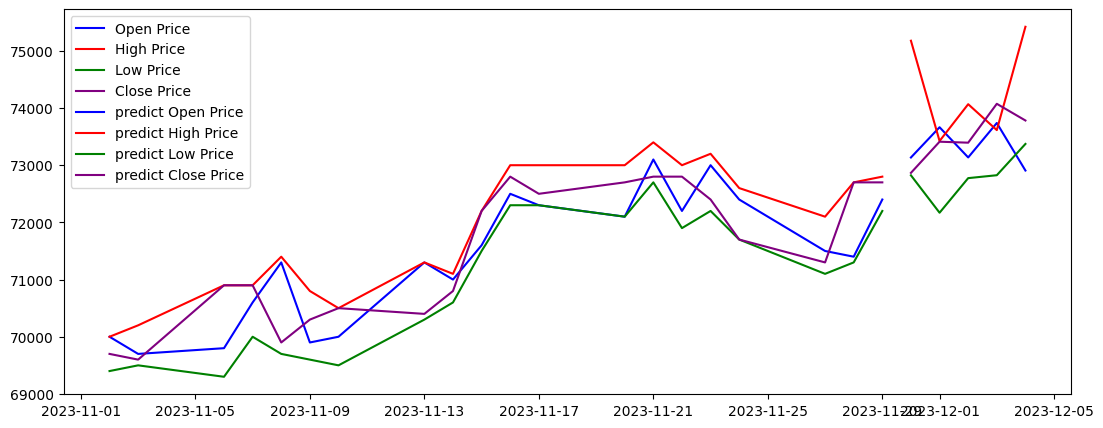

In [ ]:
import matplotlib.pyplot as plt
cols = predict_stock_df.columns

plt.figure(figsize = (13 , 5))
recent_df = standard_stock.tail(20)

plt.plot(recent_df['Open'] , label = 'Open Price' , color = 'blue')
plt.plot(recent_df['High'] , label = 'High Price' , color = 'red')
plt.plot(recent_df['Low'] , label = 'Low Price' , color = 'green')
plt.plot(recent_df['Close'] , label = 'Close Price' , color = 'purple')


plt.plot(predict_stock_df['Open'] , label = 'predict Open Price' , color = 'blue')
plt.plot(predict_stock_df['High'] , label = 'predict High Price' , color = 'red')
plt.plot(predict_stock_df['Low'] , label = 'predict Low Price' , color = 'green')
plt.plot(predict_stock_df['Close'] , label = 'predict Close Price' , color = 'purple')
plt.legend()
plt.show()

In [4]:
import pickle
import pandas as pd
import numpy as np
import FinanceDataReader as fd
from datetime import date , timedelta

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.layers import Dense , LSTM , Dropout
from tensorflow.keras.models import Sequential , load_model
from tensorflow.keras.callbacks import ModelCheckpoint , EarlyStopping

In [1]:
class CreateModel:
    def __init__(self , code , sday , fday):
        self.code = code
        self.sday = sday
        self.fday = fday
    def makeModel(self):
        today = date.today()
        stock = fd.DataReader(self.code, '1990-01-03', today)
        stock.drop(['Change', 'Volume'], axis=1, inplace=True)
        dow = fd.DataReader('DJI', '1990-01-02', today)
        nas = fd.DataReader('IXIC', '1990-01-02', today)
        nvda = fd.DataReader('NVDA', '1990-01-03', today)
        amd = fd.DataReader('AMD', '1990-01-03', today)
        intc = fd.DataReader('INTC', '1990-01-03', today)

        kospi = fd.DataReader('KS11', '1990-01-02', today)
        stock['dow'] = dow['Close']
        stock['nas'] = nas['Close']
        stock['nvda'] = nvda['Close']
        stock['amd'] = amd['Close']
        stock['intc'] = intc['Close']
        stock['kospi'] = kospi['Close']


        stock.fillna(method='ffill')
        scaler = StandardScaler()
        stock.iloc[:, 0:stock.shape[1]] = scaler.fit_transform(stock.iloc[:, 0:stock.shape[1]])

        with open('../model/'+self.code+str(self.sday)+str(self.fday)+'_scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)

        x = []
        y = []

        for i in range(len(stock) - self.sday - self.fday + 1):
            x.append(stock.iloc[i:i + self.sday])
            y.append(stock.iloc[i + self.sday: i + self.sday + self.fday , :4])

        x = np.array(x)
        y = np.array(y)

        x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, shuffle=True)

        y_train = y_train.reshape(-1, y_train.shape[1] * y_train.shape[2])
        y_val = y_val.reshape(-1, y_val.shape[1] * y_val.shape[2])

        model = Sequential()

        model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2])))
        model.add(Dropout(0.3))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(y_train.shape[1]))

        model.compile(loss='mae', optimizer='adam', metrics='mae')

        mc = ModelCheckpoint('../model/'+self.code+str(self.sday)+str(self.fday)+'_model.h5', monitor='val_mae', save_best_only=True)
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)

        history = model.fit(x_train, y_train, epochs=1000, callbacks=[mc, es], validation_data=[x_val, y_val])

In [5]:
today = date.today()
stock = fd.DataReader('005930', '1990-01-03', today)
stock.drop(['Change', 'Volume'], axis=1, inplace=True)
dow = fd.DataReader('DJI', '1990-01-02', today)
nas = fd.DataReader('IXIC', '1990-01-02', today)
nvda = fd.DataReader('NVDA', '1990-01-03', today)
amd = fd.DataReader('AMD', '1990-01-03', today)
intc = fd.DataReader('INTC', '1990-01-03', today)

kospi = fd.DataReader('KS11', '1990-01-02', today)
stock['dow'] = dow['Close']
stock['nas'] = nas['Close']
stock['nvda'] = nvda['Close']
stock['amd'] = amd['Close']
stock['intc'] = intc['Close']
stock['kospi'] = kospi['Close']

In [6]:
stock.fillna(method='ffill')

,Open,High,Low,Close,dow,nas,nvda,amd,intc,kospi
Date,,,,,,,,,,
1999-08-12,3800,3860,3730,3800,10789.389648,2549.489990,0.438406,9.250000,21.848972,949.35
1999-08-13,3699,3779,3610,3700,10973.650391,2637.810059,0.433627,9.468750,22.945913,917.47
1999-08-16,3680,3890,3640,3800,11046.790039,2645.280029,0.416903,9.375000,22.604244,907.28
1999-08-17,3820,3870,3660,3680,11117.080078,2671.229980,0.418098,9.312500,22.730124,873.70
1999-08-18,3600,3760,3540,3680,10991.379883,2657.729980,0.427654,9.281250,22.586246,868.94
...,...,...,...,...,...,...,...,...,...,...
2023-11-23,73000,73200,72200,72400,35273.031250,14265.860352,487.160004,122.510002,43.669998,2514.96
2023-11-24,72400,72600,71700,71700,35390.148438,14250.849609,477.760010,122.309998,43.959999,2496.63
2023-11-27,71500,72100,71100,71300,35333.468750,14241.019531,482.420013,122.650002,44.080002,2495.66
